In [99]:
%reset -f

In [100]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io as reader
from matplotlib import pyplot as plt 
import utils
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [101]:
class Net(nn.Module):
    def __init__(self, layers):
        super(Net, self).__init__()
        self.layers = layers
        self.iter = 0
        self.activation = nn.Tanh()
        self.linear = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linear[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linear[i].bias.data)

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        a = self.activation(self.linear[0](x))
        for i in range(1, len(self.layers) - 2):
            z = self.linear[i](a)
            a = self.activation(z)
        a = self.linear[-1](a)
        return a

In [102]:
def exact_u(x):
    return x[:, [1]] * np.cos(5 * np.pi * x[:, [0]]) + np.power(x[:, [1]] * x[:, [0]], 3)

In [103]:
def get_kg_data(exact_u):
    x = np.expand_dims(np.linspace(0, 1, 100), axis=1)
    t = np.expand_dims(np.linspace(0, 1, 100), axis=1)
    X, T = np.meshgrid(x, t)
    x_test_np = np.concatenate(
        (np.vstack(np.expand_dims(X, axis=2)), 
         np.vstack(np.expand_dims(T, axis=2))), axis=-1)
    usol = exact_u(x_test_np)
    x = torch.from_numpy(x).float().to(device)
    t = torch.from_numpy(t).float().to(device)
    x_test = torch.from_numpy(x_test_np).float().to(device)
    x_test_exact = torch.from_numpy(usol).float().to(device)
    return x, t, x_test, x_test_exact

In [104]:
x, t, x_test_point, x_test_exact = get_kg_data(exact_u)
Exact = x_test_exact.cpu().detach().numpy().reshape(100, 100)

In [105]:
# if error < self.top1:
#     self.top1 = error
#     torch.save(self.net.state_dict(), './best_model.pth')
# 载入best_model.pth
net = Net([2, 20, 20, 20, 20, 1]).to(device)
net.load_state_dict(torch.load('./best_model.pth'))

<All keys matched successfully>

In [106]:
from pyDOE import lhs
lb = np.array([0.0, 0.0])
ub = np.array([1.0, 1.0])
def random_fun(num):
    temp = torch.from_numpy(lb + (ub - lb) * lhs(2, num)).float().to(device)
    return temp

In [107]:
imgl = net(x_test_point).reshape([100,100])

In [108]:
j0 = 0
J = 5
e = 0.01

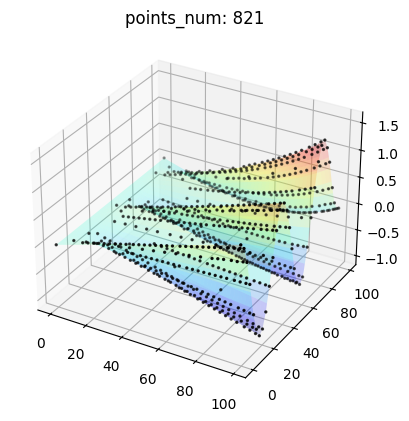

<Figure size 640x480 with 0 Axes>

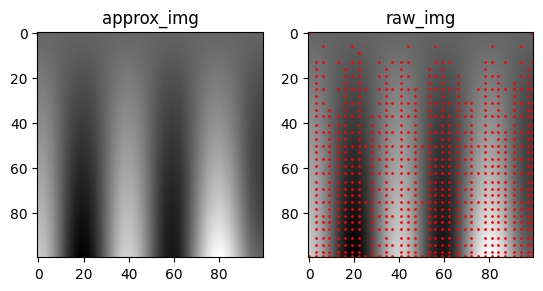

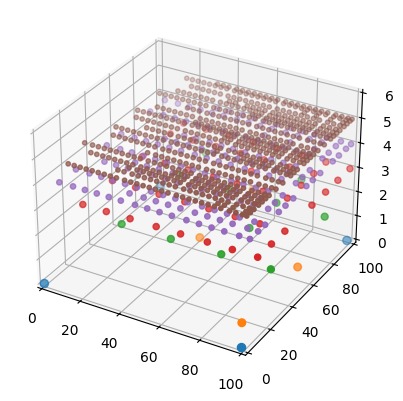

In [109]:
xc1 = torch.arange(lb[1], ub[1], 1/imgl.shape[0]).reshape((-1,1)).to(device)
xr1 = torch.arange(lb[0], ub[0], 1/imgl.shape[1]).reshape((-1,1)).to(device)
iwtmodel = utils.torchIWT(j0, J, e).to(device)
approx, indicies = iwtmodel.get_Iwt2d(imgl, xc1, xr1)
l=-1
utils.show_approx(imgl.cpu().detach().numpy(), approx.cpu().detach().numpy(), indicies, level_points=l, s=1, cmap='gray', show_2d_points=True, al=0.2)
utils.show_3d_points(approx.cpu().detach().numpy(), indicies, level_points=l)

In [110]:
err = np.linalg.norm(imgl.cpu().detach().numpy() - Exact, 2) / np.linalg.norm(Exact, 2) 
print('Relative L2 error: {:.4e}'.format(err))

Relative L2 error: 1.0809e-03


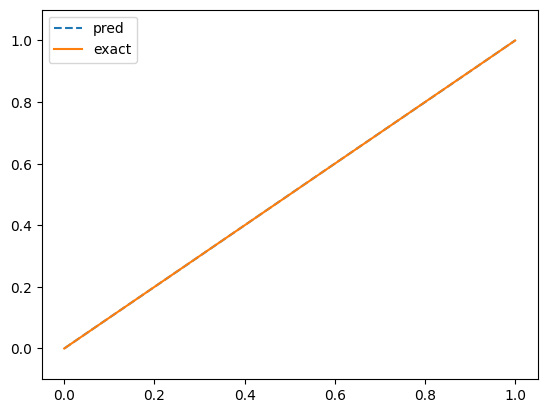

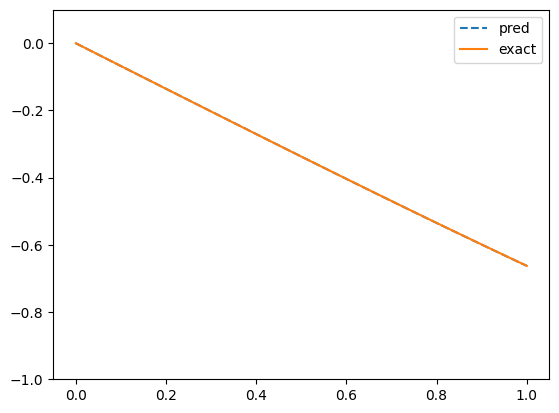

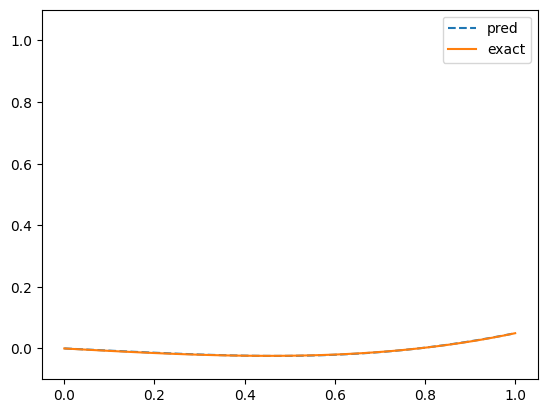

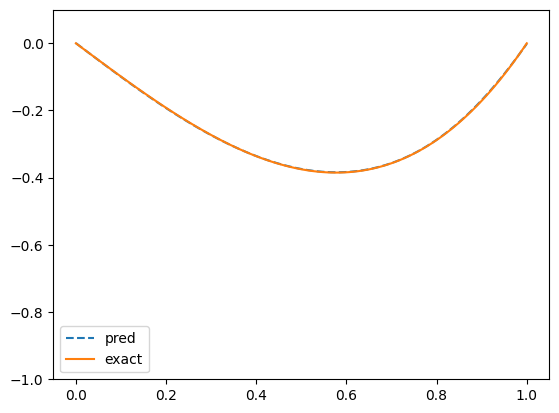

In [111]:
x_test_pred = net(x_test_point)
x_test_pred = x_test_pred.reshape(x.shape[0], t.shape[0])
x_test_pred = x_test_pred.to('cpu').detach().numpy()
x_test_exact = x_test_exact.reshape(x.shape[0], t.shape[0])
x_test_exact = x_test_exact.to('cpu').detach().numpy()
x1 = x.cpu().detach().numpy()
t1 = t.cpu().detach().numpy()
plt.figure()
plt.plot(x1, x_test_pred[:, 0], label='pred', linestyle='--')
plt.plot(x1, x_test_exact[:, 0], label='exact')
plt.ylim([-0.1, 1.1])
plt.legend()
plt.figure()
plt.plot(x1, x_test_pred[:, 25], label='pred', linestyle='--')
plt.plot(x1, x_test_exact[:, 25], label='exact')
plt.ylim([-1.0, 0.1])
plt.legend()
plt.figure()
plt.plot(x1, x_test_pred[:, 50], label='pred', linestyle='--')
plt.plot(x1, x_test_exact[:, 50], label='exact')
plt.ylim([-0.1, 1.1])
plt.legend()
plt.figure()
plt.plot(x1, x_test_pred[:, -1], label='pred', linestyle='--')
plt.plot(x1, x_test_exact[:, -1], label='exact')
plt.ylim([-1.0, 0.1])
plt.legend()

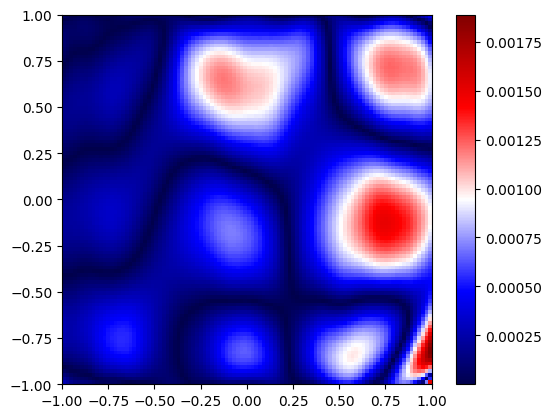

In [112]:
# error
plt.imshow(np.abs(x_test_pred - x_test_exact), extent=(-1, 1, -1, 1), cmap='seismic')
# 颜色条
plt.colorbar()
plt.show()